In [1]:
import sqlite3
import faiss
import numpy as np
from IPython.display import HTML, display, Audio, Image
from sentence_transformers import SentenceTransformer
from PIL import Image as PILImage
import json
import os

In [2]:
db_path = 'database/multimodal_rag.db'

In [3]:
text_model = SentenceTransformer('all-mpnet-base-v2')  # For text queries
image_model = SentenceTransformer('clip-ViT-B-32')    # For image queries
audio_model = SentenceTransformer('all-mpnet-base-v2')

In [4]:
def initialize_faiss_index(modality: str):
    """Load embeddings from the database into a FAISS index by modality."""
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()
    
    try:
        # Retrieve embeddings and metadata for the specified modality
        cursor.execute(f'''
            SELECT id, embedding, metadata 
            FROM embeddings 
            WHERE modality=?
        ''', (modality,))
        rows = cursor.fetchall()
        
        if not rows:
            print(f"No embeddings found for modality '{modality}'.")
            return None, []
        
        # Convert BLOBs to numpy arrays and validate dimensions
        embeddings = []
        valid_ids = []
        metadata_list = []
        
        for row in rows:
            try:
                emb = np.frombuffer(row[1], dtype=np.float32)
                embeddings.append(emb)
                valid_ids.append(row[0])
                metadata_list.append(json.loads(row[2]))
            except Exception as e:
                print(f"Error decoding embedding ID {row[0]}: {str(e)}")
        
        if not embeddings:
            print(f"No valid embeddings found for modality '{modality}'.")
            return None, [], []
        
        # Validate consistent dimensions
        dimension = embeddings[0].shape[0]
        for emb in embeddings:
            if emb.shape[0] != dimension:
                print("Dimension mismatch detected in embeddings.")
                return None, [], []
        
        # Initialize FAISS index and add embeddings
        index = faiss.IndexFlatL2(dimension)
        index.add(np.array(embeddings))
        
        print(f"FAISS index ready for '{modality}': {index.ntotal} embeddings (dim={dimension})")
        return index, valid_ids, metadata_list
    
    finally:
        conn.close()

In [5]:
def query_database(query_text: str, modality: str, top_k: int = 5):
    """Query the database for a specific modality and return results."""
    # Initialize FAISS index for the specified modality
    index, valid_ids, metadata_list = initialize_faiss_index(modality)
    if not index:
        return []
    
    # Generate query embedding using the appropriate model
    try:
        if modality == 'text':
            query_embedding = text_model.encode([query_text], convert_to_numpy=True)
        elif modality == 'image':
            query_embedding = image_model.encode([query_text], convert_to_numpy=True)
        elif modality == 'audio':
            query_embedding = audio_model.encode([query_text], convert_to_numpy=True)
        else:
            print(f"Unsupported modality: {modality}")
            return []
        
        distances, indices = index.search(query_embedding.astype('float32'), top_k)
    except Exception as e:
        print(f"Error during FAISS search: {str(e)}")
        return []

    # Retrieve results from metadata list
    results = []
    for i, idx in enumerate(indices[0]):
        if idx < 0 or idx >= len(metadata_list):
            continue
        
        metadata = metadata_list[idx]
        results.append({
            "id": valid_ids[idx],
            "metadata": metadata,
            "score": float(distances[0][i])
        })
    
    return results

In [6]:
def display_results(results, modality: str):
    """Display results based on the query modality."""
    if not results:
        print("No results found.")
        return
    
    print(f"Top {len(results)} results:")
    
    for i, result in enumerate(results):
        print(f"\nResult {i+1}:")
        
        if modality == 'text':
            print(f"Content: {result['metadata'].get('content', 'N/A')}")
        
        elif modality == 'image':
            image_path = result['metadata'].get('path', '')
            if os.path.exists(image_path):
                display(PILImage.open(image_path))
            else:
                print(f"Image file not found: {image_path}")
        
        elif modality == 'audio':
            audio_path = result['metadata'].get('path', '')
            if os.path.exists(audio_path):
                display(Audio(audio_path))
            else:
                print(f"Audio file not found: {audio_path}")
        
        elif modality == 'video':
            video_path = result['metadata'].get('path', '')
            if os.path.exists(video_path):
                display(HTML(f'''
                    <video width="500" controls>
                        <source src="{video_path}" type="video/mp4">
                        Your browser does not support the video tag.
                    </video>
                '''))
            else:
                print(f"Video file not found: {video_path}")
        
        else:
            print("Unsupported modality.")

FAISS index ready for 'text': 6 embeddings (dim=768)
Top 2 results:

Result 1:
Content: The capital of France is Paris.

Result 2:
Content: Sample text 2
FAISS index ready for 'image': 6 embeddings (dim=512)
Top 1 results:

Result 1:


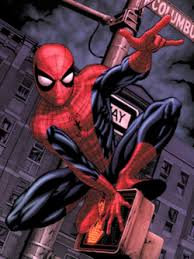

FAISS index ready for 'audio': 1 embeddings (dim=768)
Top 1 results:

Result 1:


In [14]:
if __name__ == "__main__":
    # Query examples for each modality
    
    # Text Query
    text_results = query_database("Tell me capital of France", "text", top_k=2)
    display_results(text_results, "text")
    
    # Image Query
    image_results = query_database("spiderman", "image", top_k=1)
    display_results(image_results, "image")
    
    # Audio Query
    audio_results = query_database("Do you have bird sounds?", "audio", top_k=2)
    display_results(audio_results, "audio")
    
